In [88]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Turn off scientific notation in Pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Import data
tn_budget = pd.read_csv('Data/Zipped_Data/tn.movie_budgets.csv.gz',
                        compression='gzip')
bom_gross = pd.read_csv('Data/Zipped_Data/bom.movie_gross.csv.gz',
                        compression='gzip')
imbd_basics = pd.read_csv('Data/Zipped_Data/imdb.title.basics.csv.gz',
                          compression='gzip')
imbd_name = pd.read_csv('Data/Zipped_Data/imdb.name.basics.csv.gz',
                        compression='gzip')
imbd_principals = pd.read_csv('Data/Zipped_Data/imdb.title.principals.csv.gz',
                              compression='gzip')

In [89]:
# Remove punctuation from producton and worldwide.
# Switch variables from string to float.
tn_budget['production_budget'] = tn_budget['production_budget']\
 .apply(lambda x: x.translate
        (str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
tn_budget['worldwide_gross'] = tn_budget['worldwide_gross']\
 .apply(lambda x: x.translate
        (str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
tn_budget['production_budget'] = pd.to_numeric(tn_budget.production_budget,
                                               downcast='float',
                                               errors='coerce')
tn_budget['worldwide_gross'] = pd.to_numeric(tn_budget.worldwide_gross,
                                             downcast='float',
                                             errors='coerce')

In [90]:
# Create column for net profit (worldwide gross minus production budget).
tn_budget['net'] = list(tn_budget.apply(lambda x:
                                        x.worldwide_gross
                                        - x.production_budget,
                                        axis=1))

# Create column for ratio (net profit divided by production budget)
tn_budget['ratio'] = list(tn_budget.apply
                          (lambda x: x.net / x.production_budget, axis=1))

# Rename column 'movie' to 'title'
tn_budget = tn_budget.rename(columns={'movie': 'title'})

# Remove whitespace, potential extra words, punctuation, 
# corrupted text, and case from titles
years = [r'\(2010\)', r"\(2011\)",
         r"\(2012\)", r"\(2013\)", r"\(2014\)",
         r"\(2015\)", r"\(2016\)", r"\(2017\)", r"\(2018\)"]
tn_budget.title = tn_budget.title.replace(years, value='', regex=True)
tn_budget.title = tn_budget.title.str.strip()
tn_budget.title = tn_budget.title.apply(lambda x: x.lower())
tn_budget.title = tn_budget.title\
 .apply(lambda x: x.translate
        (str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
tn_budget.title = tn_budget.title.replace(['the', 'and', 'â',
                                          '\x80\x99'], value='', regex=True)

# Remove month and year from date. Drop redundant columns
tn_budget['year'] = list(tn_budget['release_date'].str[-4:])
tn_budget = tn_budget.drop(columns=['id', 'domestic_gross', 'release_date'])

In [91]:
# Remove 'studio', 'domestic_gross', 'foreign_gross' column.
# Set 'foreign_gross' to float and 'year' to string
bom_gross = bom_gross.drop(columns=['domestic_gross', 'foreign_gross'])
bom_gross['year'] = bom_gross['year'].astype(str)

# Remove whitespace, potential extra words, punctuation, 
# corrupted text, and case from titles
years = [r'\(2010\)', r"\(2011\)",
         r"\(2012\)", r"\(2013\)", r"\(2014\)",
         r"\(2015\)", r"\(2016\)", r"\(2017\)", r"\(2018\)"]
bom_gross.title = bom_gross.title.replace(years, value='', regex=True)
bom_gross.title = bom_gross.title.str.strip()
bom_gross.title = bom_gross.title.apply(lambda x: x.lower())
bom_gross.title = bom_gross.title\
 .apply(lambda x: x.translate
        (str.maketrans
         ('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
bom_gross.title = bom_gross.title.replace(['the', 'and', 'â',
                                          '\x80\x99'], value='', regex=True)

In [92]:
# Merge tn_budget and bom_gross
merged_df = pd.merge(tn_budget, bom_gross, on=["title", "year"], how="left")

# Replace null studio values
merged_df['studio'] = merged_df.studio.fillna('Unknown')

In [93]:
# Create 'year' string column from 'start_year'
imbd_basics['year'] = imbd_basics['start_year'].astype(str)

# Drop unused columns
imbd_basics = imbd_basics.drop(columns=['original_title', 'start_year'])

# Rename column for easier merging
imbd_basics = imbd_basics.rename(columns={'primary_title': 'title'})

# Remove whitespace, potential extra words, punctuation, 
# corrupted text, and case from titles
years = [r'\(2010\)', r"\(2011\)",
         r"\(2012\)", r"\(2013\)", r"\(2014\)",
         r"\(2015\)", r"\(2016\)", r"\(2017\)", r"\(2018\)"]
imbd_basics.title = imbd_basics.title.replace(years, value='', regex=True)
imbd_basics.title = imbd_basics.title.str.strip()
imbd_basics.title = imbd_basics.title.apply(lambda x: x.lower())
imbd_basics.title = imbd_basics.title\
 .apply(lambda x: x.translate
        (str.maketrans
         ('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
imbd_basics.title = imbd_basics.title.replace(['the', 'and', "â",
                                              '\x80\x99'],
                                              value='',
                                              regex=True)

In [94]:
# Merge imbd_basics with merged datafile
merged_df2 = pd.merge(merged_df, imbd_basics, on=["title", "year"], how="left")

# Change year to integer, and remove all films made
# before 2010. Turn year back to string.
merged_df2['year'] = merged_df2['year'].astype(int)
merged_df2 = merged_df2.loc[merged_df2.year >= 2010]
merged_df2['year'] = merged_df2['year'].astype(str)

In [95]:
# Merge imbd_principals and imbd_name
imbd_name_prin = pd.merge(imbd_principals, imbd_name,
                          on=["nconst"], how="left")

# Remove extraneous columns
imbd_name_prin = imbd_name_prin.drop(columns=['ordering',
                                              'nconst', 'job',
                                              'characters', 'birth_year',
                                              'death_year',
                                              'primary_profession',
                                              'known_for_titles'])

In [96]:
# Create list of directors from imbd_name_prin
directors = imbd_name_prin.loc[imbd_name_prin.category == 'director']

In [97]:
# Merge list of directors with merged document
merged_df3 = pd.merge(merged_df2, directors, on=["tconst"], how="left")

# Remove extra columns, rename primary_name to director
merged_df3 = merged_df3.drop(columns=['category', 'runtime_minutes',
                                      'genres'])
merged_df3 = merged_df3.rename(columns={'primary_name': 'director'})

# Fill in null values for director
merged_df3['director'] = merged_df3.director.fillna('Not listed')

In [98]:
# Remove duplicate titles
merged_df_cleaned = merged_df3.loc[~(merged_df3.title.duplicated())]

# Drop extra column
merged_df_cleaned = merged_df_cleaned.drop(columns='tconst')

In [99]:
# Create list of films with top ROI
top_net = merged_df_cleaned.sort_values(by=['net'], ascending=False)[:10]

# Create list of films with top ROI
top_ratio = merged_df_cleaned.sort_values(by=['ratio'], ascending=False)[:10]

# Create a list of 20 studios with the top ratio means
studio_ratio_mean = (merged_df_cleaned.groupby
                     (['studio']).ratio.mean().
                     sort_values(ascending=False)[:20])

# Create a list of 20 directors with the top ratio means
director_ratio_mean = (merged_df_cleaned.groupby
                       (['director']).ratio.mean().
                       sort_values(ascending=False)[0:20])

# Create a list of 19 directors with the top ROI means,
# with top value removed
director_ratio_mean_19 = (merged_df_cleaned.groupby
                          (['director']).ratio.mean().
                          sort_values(ascending=False)[1:20])

# Provides a count for the number of films made by
# each director with a top-20 ROI
directors_roi_count = (merged_df_cleaned.groupby
                       ('director')['ratio', 'title'].agg
                       ({'ratio': 'mean', 'title': 'nunique'}).sort_values
                       (by='ratio', ascending=False))[0:20].reset_index()

In [102]:
top_net.title

5                     avengers infinity war
4           star wars ep vii  force awakens
29                           jurassic world
57                                furious 7
24                                 avengers
209    harry potter deathly hallows part ii
33                            black panther
97            jurassic world fallen kingdom
134                                  frozen
119                    beauty and the beast
Name: title, dtype: object

In [103]:
# Clean titles
top_net.title = top_net.title.replace(['beauty   beast'],
                                      value='beauty and the beast', regex=True)
top_net.title = top_net.title.replace(['black panr'],
                                      value='black panther', regex=True)
top_net.title = top_net.title\
 .replace(['harry potter   deathly hallows part ii'],
          value='harry potter deathly hallows part ii', regex=True)
top_net.title = top_net.title\
 .replace(['star wars ep vii  force awakens'],
          value='star wars ep vii force awakens', regex=True)

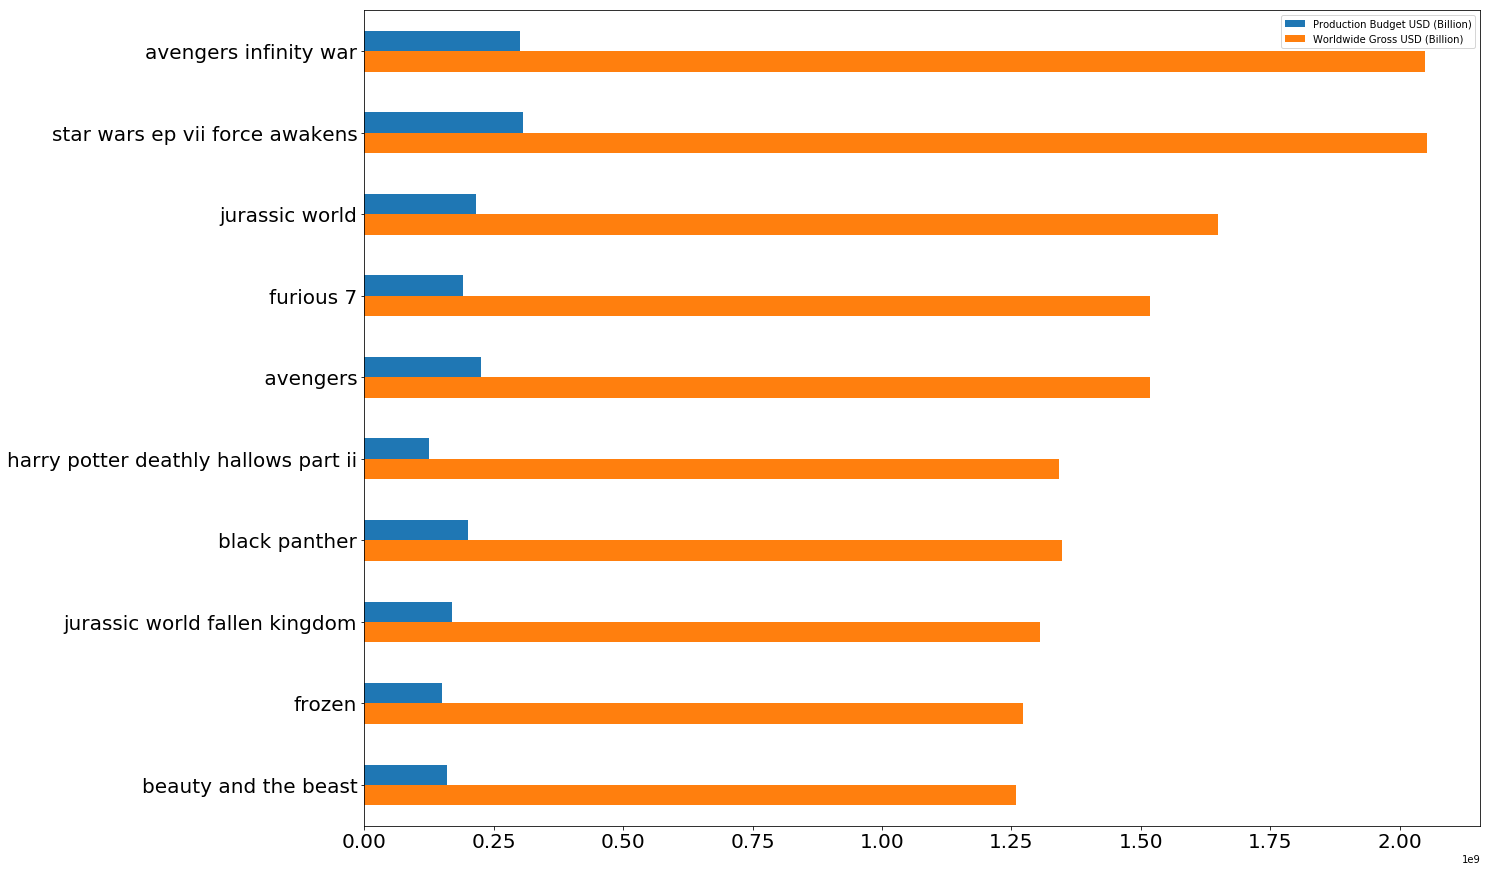

In [104]:
# Create earnings/cost graph for films with top net
index = list(top_net['title'])
production_budget = list(top_net['production_budget'])
worldwide_gross = list(top_net['worldwide_gross'])
df = pd.DataFrame({'Production Budget USD (Billion)':
                   production_budget,
                   'Worldwide Gross USD (Billion)':
                   worldwide_gross}, index=index,)
ax = df.plot.barh(figsize=(20, 15), rot=0, fontsize=20).invert_yaxis()

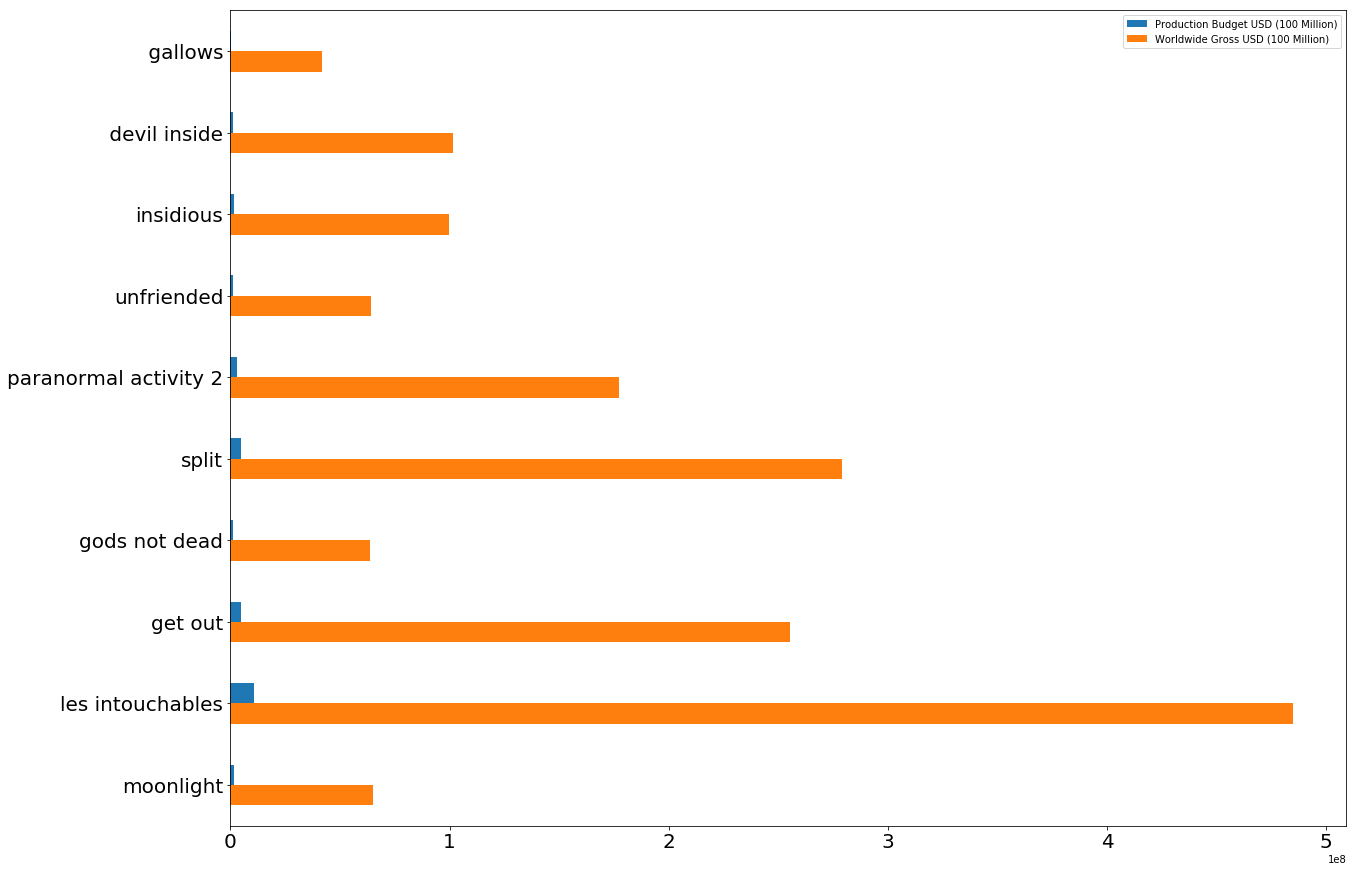

In [83]:
# Create earnings/cost graph for films with top ROI
index = list(top_ratio['title'])
production_budget = list(top_ratio['production_budget'])
worldwide_gross = list(top_ratio['worldwide_gross'])
df = pd.DataFrame({'Production Budget USD (100 Million)': production_budget,
                   'Worldwide Gross USD (100 Million)': worldwide_gross},
                  index=index)
ax = df.plot.barh(figsize=(20, 15), rot=0, fontsize=20).invert_yaxis()

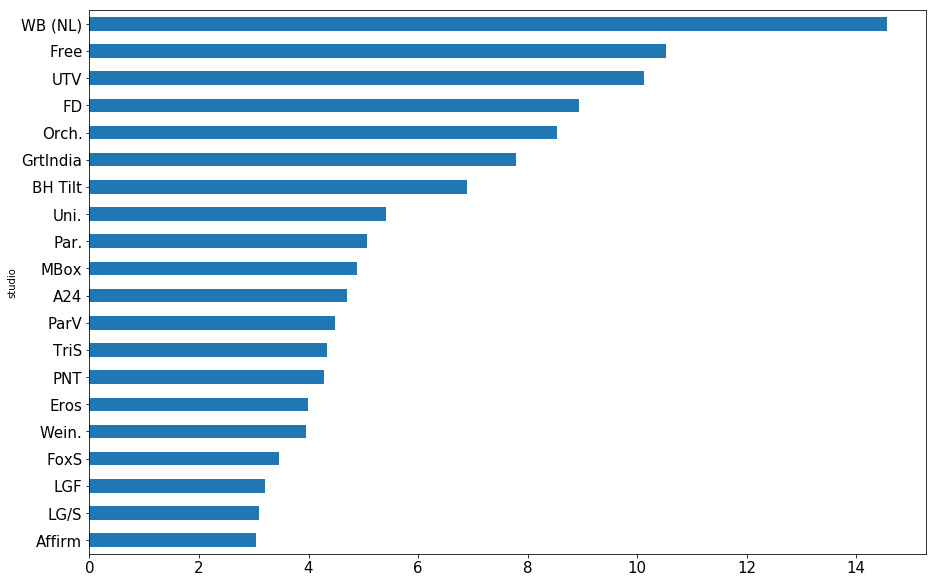

In [84]:
# Creates a graph of the 20 studios with the best ROI
studio_ratio_mean.plot(kind='barh',
                       figsize=(15, 10), fontsize=15).invert_yaxis()

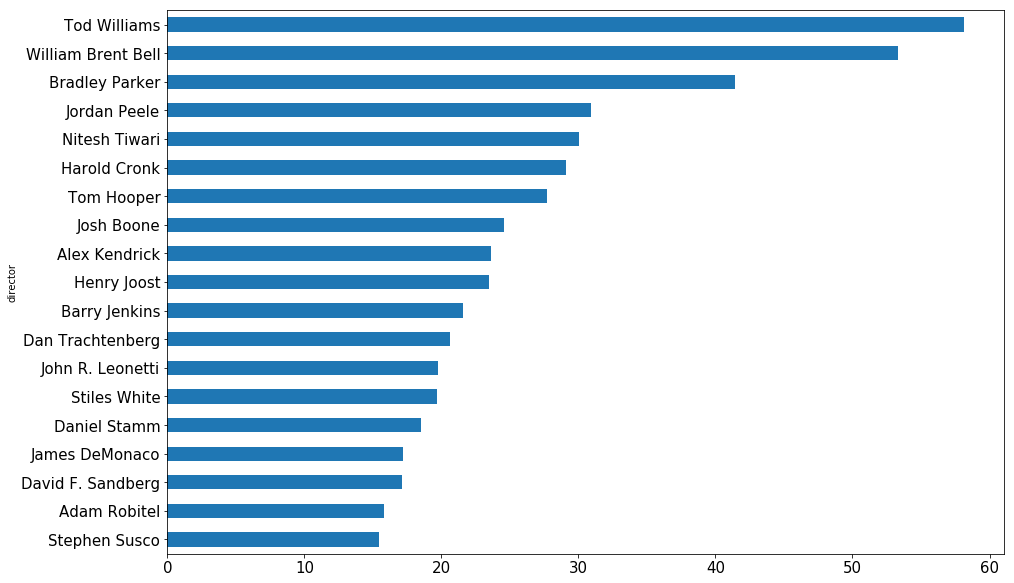

In [85]:
# Creates a graph of the 2-20 directors with the best ROI
director_ratio_mean_19.plot(kind='barh',
                            figsize=(15, 10), fontsize=15).invert_yaxis()

([<matplotlib.axis.XTick at 0x1b70488fd30>,
 <a list of 4 Text xticklabel objects>)

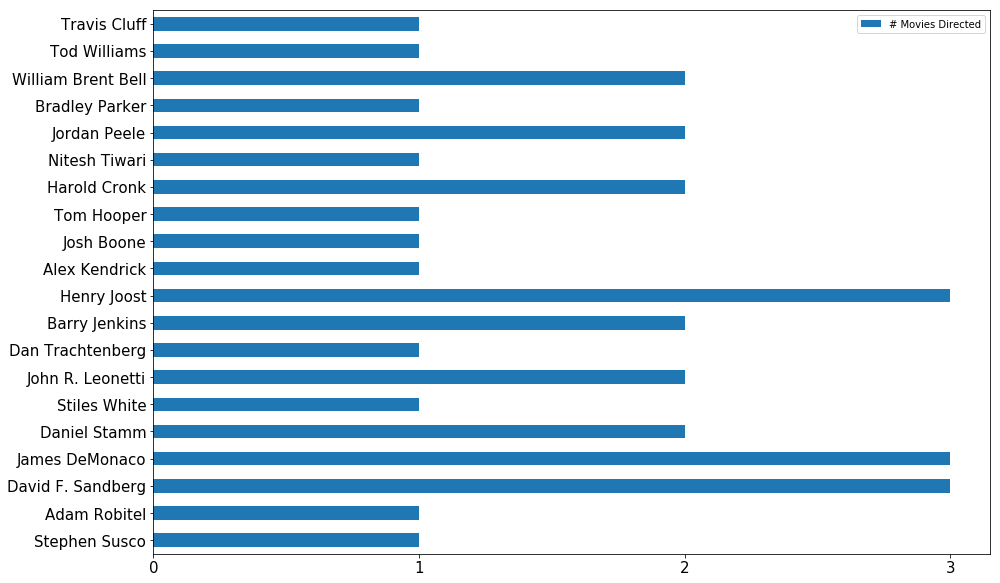

In [86]:
index = list(directors_roi_count['director'])
title_count = list(directors_roi_count['title'])
df = pd.DataFrame({'# Movies Directed': title_count},
                  index=index)
ax = df.plot.barh(figsize=(15, 10), rot=0, fontsize=15).invert_yaxis()
plt.xticks(np.arange(0, 4, 1))